# RSNA2022 Hands-on: Creating Custom Neural Network Architectures in PyTorch


### Task
To show how to create custom neural network architectures in Pytorch using the intracranial hemorrhage dataset from the RSNA ICH challenge.

### Requirements

1. Basic understanding of machine learning and deep learning
2. Programming in Python
3. Prior experience building simple classification models


### Learning Objectives

At the end of this activity, you will be able to:

1. Explain the syntax of PyTorch model architecture
2. Load pretrained architectures and modify them

### Acknowledgements

The dataset used in this notebook is derived from the RSNA Intracranial Hemorrhage Detection challenge hosted on Kaggle in 2019 (https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection). 

This notebook was authored by Ian Pan (ianpan358@gmail.com), and Felipe Kitamura (kitamura.felipe@gmail.com). 

# Introduction
In this notebook, we will train a deep learning model to classify intracranial hemorrhage in head CT on a slice-wise basis. We will start by installing and importing the libraries we will use.

## Install and Import Packages

In [ ]:
# Install required packages
!pip install --quiet "pandas" "ipython[notebook]" "torchvision" "setuptools==59.5.0" "torch>=1.8" "torchmetrics>=0.7" "seaborn" "pytorch-lightning>=1.4" "timm" "transformers==4.12.5" "lightning-bolts"


     |████████████████████████████████| 952 kB 14.4 MB/s 
     |████████████████████████████████| 529 kB 50.9 MB/s 
     |████████████████████████████████| 798 kB 26.2 MB/s 
     |████████████████████████████████| 549 kB 61.8 MB/s 
     |████████████████████████████████| 3.1 MB 32.0 MB/s 
     |████████████████████████████████| 329 kB 70.9 MB/s 
     |████████████████████████████████| 182 kB 68.6 MB/s 
     |████████████████████████████████| 880 kB 59.7 MB/s 
     |████████████████████████████████| 3.3 MB 42.2 MB/s 
     |████████████████████████████████| 125 kB 69.7 MB/s 
     |████████████████████████████████| 87 kB 7.1 MB/s 
     |████████████████████████████████| 1.6 MB 33.8 MB/s 


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
import albumentations as A
import pandas as pd
import seaborn as sn
import torch
from IPython.core.display import display
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import Callback
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
import timm
from tqdm import tqdm


BATCH_SIZE = 32 if torch.cuda.is_available() else 16
print("GPU Backend" if torch.cuda.is_available() else "CPU Backend")



GPU Backend


## Download Data

The dataset for this notebook is derived from the 2019 RSNA Intracranial Hemorrhage Detection challenge hosted on Kaggle (https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/data). 

To streamline this notebook and reduce the size of the dataset, 1,600 head CT slices from the original dataset were randomly sampled (800 positive, 800 negative), converted from DICOM to PNG, and downsampled to a resolution of 256 x 256 pixels. During the conversion, a standard brain window (WL=40, WW=80) was used to convert the image into 8-bit. The size of this reduced dataset is around 24 MB.

In [ ]:
# Download data
!wget https://github.com/kitamura-felipe/RSNA2022-ICH-CustomPyTorchModel/raw/main/bin2.zip
!unzip -qqo bin2.zip

--2022-11-25 02:44:47--  https://github.com/kitamura-felipe/RSNA2022-ICH-CustomPyTorchModel/raw/main/bin2.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kitamura-felipe/RSNA2022-ICH-CustomPyTorchModel/main/bin2.zip [following]
--2022-11-25 02:44:47--  https://raw.githubusercontent.com/kitamura-felipe/RSNA2022-ICH-CustomPyTorchModel/main/bin2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24975580 (24M) [application/zip]
Saving to: ‘bin2.zip.6’

bin2.zip.6          100%[===================>]  23.82M  --.-KB/s    in 0.07s   

2022-11-25 02:44:47 (365 MB/s) - ‘bin2.zip.6’ saved [24975580/

## Explore Data

In the process of converting the DICOMS to PNGs, the filenames were changed to "IM_{XXXX}.png". Currently, there is no mapping in the DataFrame between the PNG filename and the labels, so we need to map them from the parent folders "Normal" or "Hemorrhage".

In [ ]:
all_images = glob.glob('bin/*/*.png')
all_images_df = pd.DataFrame(dict(imgfile=all_images))
get_sop = lambda x: x.split('/')[-1].split('-')[-1].replace('.png', '')
all_images_df['SOPInstanceUID'] = all_images_df.imgfile.apply(get_sop)
all_images_df['ICH'] = all_images_df.imgfile.apply(lambda x: 0 if x.split('/')[1] == "Normal" else 1)
label_cols = 'ICH'
df = all_images_df
df.head()

,imgfile,SOPInstanceUID,ICH
0,bin/Normal/ID_0c98f55d9.png,ID_0c98f55d9,0
1,bin/Normal/ID_0f1de192d.png,ID_0f1de192d,0
2,bin/Normal/ID_06537697e.png,ID_06537697e,0
3,bin/Normal/ID_02bc97121.png,ID_02bc97121,0
4,bin/Normal/ID_00b350e99.png,ID_00b350e99,0


We can look at some example images.

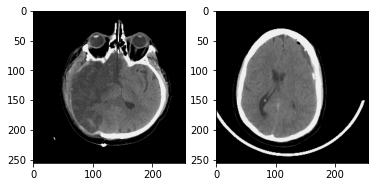

In [ ]:
# Re-run code block to see different images
positives = df[df['ICH'] == 1]
negatives = df[df['ICH'] == 0]

plt.subplot(1,2,1)
plt.imshow(cv2.imread(np.random.choice(positives.imgfile)), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(cv2.imread(np.random.choice(negatives.imgfile)), cmap='gray')
plt.show()

## Split the Data

We will now split the data into a single train-validation-test split using a 70%-10%-20% partition. When the dataset was processed, only 1 study per patient was obtained. 

In [ ]:
train_frac, val_frac, test_frac = 0.7, 0.1, 0.2

all_studies = df.SOPInstanceUID
n_train = int(train_frac * len(all_studies))
n_test = int(test_frac * len(all_studies))
train_studies = np.random.choice(all_studies, n_train, replace=False)
# Remove train studies from available studies and sample test studies
not_train_studies = list(set(all_studies) - set(train_studies))
test_studies = np.random.choice(not_train_studies, n_test, replace=False)
# Validation studies are just the leftover ones
val_studies = list(set(not_train_studies) - set(test_studies))

print(f'TRAIN: N={len(train_studies)} studies')
print(f'VAL:   N={len(val_studies)} studies')
print(f'TEST:  N={len(test_studies)} studies')

overlap = list(set(train_studies) & set(val_studies) & set(test_studies))
if len(overlap) == 0:
  print('\nThere is no overlap across the 3 sets.')


train_df = df[df.SOPInstanceUID.isin(train_studies)]
val_df = df[df.SOPInstanceUID.isin(val_studies)]
test_df = df[df.SOPInstanceUID.isin(test_studies)]

print(f'\nTRAIN: N={len(train_df)} images')
print(f'VAL:   N={len(val_df)} images')
print(f'TEST:  N={len(test_df)} images')

TRAIN: N=1120 studies
VAL:   N=160 studies
TEST:  N=320 studies

There is no overlap across the 3 sets.

TRAIN: N=1120 images
VAL:   N=160 images
TEST:  N=320 images


## Creating a PyTorch Dataset

We are using PyTorch to train our model. The first step is to create a Dataset class that loads the data into memory, performs any necessary transforms, and returns tensors for the model inputs.

We will also be using the Albumentations library to create a list of transforms, including data augmentation during training.

In [ ]:
IMG_SIZE = (256, 256)

class ICHDataset(Dataset):

  def __init__(self,
               imgfiles,
               labels,
               transforms):
    self.imgfiles = imgfiles
    self.labels = labels
    self.transforms = transforms

  def __len__(self):
    return len(self.imgfiles)
  
  def __getitem__(self, i):
    # Load image as grayscale
    img = cv2.imread(self.imgfiles[i], 0)
    # Currently image shape is (H,W)- add extra dimension so it is (H,W,1)
    img = np.expand_dims(img, axis=-1)
    # Apply any necessary transforms, using albumentations (see below)
    img = self.transforms(image=img)['image']
    # Convert to channels-FIRST torch tensor
    img = torch.from_numpy(img.transpose(2,0,1)).float()
    # Get labels and convert to torch tensor
    labels = torch.from_numpy(np.array([self.labels[i]])).float() 
    return img, labels


train_transforms = A.Compose([
  A.Resize(*IMG_SIZE),
  A.Normalize(mean=0.5, std=0.5),
  A.HorizontalFlip(p=0.5),
  A.VerticalFlip(p=0.5),
  A.RandomBrightnessContrast(p=0.2),
  A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=30,
                     border_mode=0, p=0.2)
], p=1)


infer_transforms = A.Compose([
  A.Resize(*IMG_SIZE),
  A.Normalize(mean=0.5, std=0.5)
], p=1)

Now, we can instantiate our training, validation, and test datasets.

In [ ]:
train_dataset = ICHDataset(imgfiles=train_df.imgfile.values,
                           labels=train_df[label_cols].values,
                           transforms=train_transforms)
val_dataset = ICHDataset(imgfiles=val_df.imgfile.values,
                         labels=val_df[label_cols].values,
                         transforms=infer_transforms)
test_dataset = ICHDataset(imgfiles=test_df.imgfile.values,
                          labels=test_df[label_cols].values,
                          transforms=infer_transforms)



```
# This is formatted as code
```

## Creating a PyTorch Model

We will be using the amazing Pytorch Image Models library created by Ross Wightman (https://github.com/rwightman/pytorch-image-models/). 

In this example, we will use a convolutional neural network pretrained on ImageNet.

By default, the instantiated model will output 1,000 classes. We will modify the fully-connected layer so that it outputs 1 class.


We will also add a dropout layer for regularization.

### Listing all the pretrained models available in the timm library.

In [ ]:
timm.list_models()

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw

In [ ]:
# We can load any of the models above by:
cnn_model = timm.create_model('efficientnet_b0', pretrained=True)
# The code below prints the model structure. It is important to notice the
# name of the final linear layer of the model so we can modify it.
cnn_model

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
      

In the case above, the last linear layer is called "classifier". This may be different for other models.

In [ ]:

class CustomCNN(LightningModule): #nn.Module):

  def __init__(self, model, lr, dropout=0.1,
               num_classes=1): 
    # Get the final output with 1000 classes and add a dropout layer
    # Add a final linear layer with 1 class
    # You can print the model to the console to see the different layers
    super().__init__()
    # Get the number of output features from the last layer
    n_feat = model.classifier.out_features 
    # Define "model" as a backbone
    self.backbone = model
    # Create a dropout layer
    self.dropout = nn.Dropout(p=dropout)
    # Create a linear layer
    self.fc = nn.Linear(n_feat , num_classes)
    # Set the initial learning rate
    self.lr = lr
  
  def forward(self, x):
    x = self.backbone(x)
    x = self.dropout(x)
    x = self.fc(x)
    return x
  
  def training_step(self, batch, batch_nb):
    x, y = batch
    loss = F.binary_cross_entropy_with_logits(self(x), y)
    return loss

  def validation_step(self, batch, batch_nb):
    x, y = batch
    loss = F.binary_cross_entropy_with_logits(self(x), y)
    self.log("val_loss", loss, prog_bar=True)
    return loss


  def configure_optimizers(self):
      return torch.optim.Adam(self.parameters(), lr=self.lr) 


cnn_model = CustomCNN(cnn_model, lr=0.001)

Another thing to consider is that our input is a grayscale image (1-channel), rather than an RGB image (3-channels), which the default model is formatted to accept. While we can simply repeat our grayscale image along the channel axis 3 times to form a pseudo-RGB image, we can also modify the first layer in our network to accept 1-channel images. 

In [ ]:
def change_num_input_channels(model, in_channels=1):
    for i, m in enumerate(model.modules()):
      if isinstance(m, (nn.Conv2d,nn.Conv3d)) and m.in_channels == 3:
        m.in_channels = in_channels
        # First, sum across channels
        W = m.weight.sum(1, keepdim=True)
        # Then, divide by number of channels
        W = W / in_channels
        # Then, repeat by number of channels
        size = [1] * W.ndim
        size[1] = in_channels
        W = W.repeat(size)
        m.weight = nn.Parameter(W)
        break
    return model


cnn_model = change_num_input_channels(cnn_model, 1)

# Test model
test_input = torch.from_numpy(np.ones((2,1,*IMG_SIZE))).float()
test_output = cnn_model(test_input)
test_output.shape

torch.Size([2, 1])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False,
                        drop_last=False)
cnn_test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False,
                             drop_last=False)

## Logging the validation loss and accuracy

Below we create a callback that will be used during training to calculate the loss and the accuracy in the validation set and log it for each epoch.

In [ ]:
acc_lst = []
loss_lst = []

class ImagePredictionLogger(Callback):
  def __init__(self, val_samples, num_samples=32):
      super().__init__()
      self.num_samples = num_samples
      self.val_imgs, self.val_labels = val_samples

  def on_validation_epoch_end(self, trainer, pl_module):
    # Bring the tensors to CPU
    val_imgs = self.val_imgs.to(device=pl_module.device)
    val_labels = self.val_labels.to(device=pl_module.device)
    # Get model prediction
    logits = pl_module(val_imgs)
    loss = F.binary_cross_entropy_with_logits(logits, val_labels)

    preds = ( logits > 0.) * 1.
    accuracy = (preds == val_labels).sum().item() / len(preds)
    
    #print("val_loss: ", loss.item())
    #print("val_acc: ", accuracy)
    acc_lst.append(accuracy)
    loss_lst.append(loss.item())
    return loss

## Train the CNN


Now we can start training! Using the default settings, this should take around 10 seconds per epoch (including validation). Feel free to play around with the hyperparameters above (number of epochs, batch size, learning rate).

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type         | Params
------------------------------------------
0 | backbone | EfficientNet | 5.3 M 
1 | dropout  | Dropout      | 0     
2 | fc       | Linear       | 1.0 K 
------------------------------------------
5.3 M     Trainable params
0         Non-trainable params
5.3 M     Total params
21.156    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


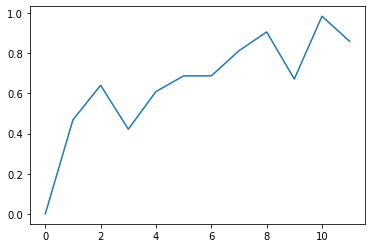

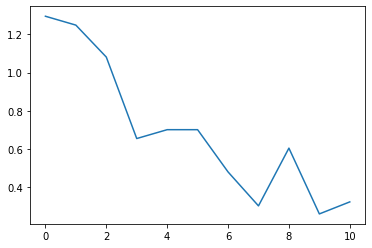

In [ ]:
from matplotlib.rcsetup import validate_verbose

val_samples = next(iter(val_loader))

# Initialize a trainer
trainer = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=5,
    callbacks=[TQDMProgressBar(refresh_rate=1), ImagePredictionLogger(val_samples, len(val_samples))],
    check_val_every_n_epoch=1,
)

# Train the model ⚡

trainer.fit(model = cnn_model,
            train_dataloaders = train_loader,
            val_dataloaders = val_loader)

plt.figure()
plt.plot(acc_lst)
plt.show()

plt.figure()
plt.plot(loss_lst[1:])
plt.show()

### Create your own Neural Network

Now, let's go back to the section "Creating a PyTorch Model" so we can create a different architecture

We suggest you the following experiments, one at a time:

1. Change the backbone (the catch is to remember the final linear layer might have different names)
2. Change the size of the linear layer
3. Create a completely custom NN.